# Quant Trading Strategies HW 3 - Madison Rusch (12365298)

## Data

In [340]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13
import quandl
import pandas as pd
import numpy as np
import functools
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import seaborn as sns
import datetime
import statsmodels.api as sm


In [341]:
trim_start = "2015-01-01"
trim_end = "2022-01-31"

# Get tickers that aren't automotive, finance, or insurance
@functools.lru_cache()
def fetch_zacks_fc(table, trim_start, trim_end, tickers = None):
    qdata = quandl.get_table(table,
                      qopts = {"columns":["ticker", "zacks_sector_code", "per_end_date", "net_lterm_debt", "tot_lterm_debt", "eps_diluted_net", "per_type", "basic_net_eps"]},
                      api_key='bXgDCzJUfS5ZxasswLcN',
                      per_end_date={"gte": trim_start, "lte": trim_end},
                      paginate = True,
                      ticker = (list(tickers) if tickers is not None else None))
    return qdata

zacks_fc = fetch_zacks_fc('ZACKS/FC', trim_start, trim_end)
automotive_stocks = list(zacks_fc[zacks_fc['zacks_sector_code'] == 5]['ticker'].unique())
finance_stocks = list(zacks_fc[zacks_fc['zacks_sector_code'] == 13]['ticker'].unique())
all_filter = automotive_stocks + finance_stocks
zacks_fc_filtered = zacks_fc[~zacks_fc['ticker'].isin(all_filter)]
tickers_by_industry = set(zacks_fc_filtered['ticker'].unique())
display(tickers_by_industry)

{'GEHI',
 'AGBA',
 'T.CCT',
 'ARCW',
 'FDMT',
 'RCIT',
 'YOGAQ',
 'EA',
 'MDXH',
 'ADRA',
 'TDUP',
 'SNT',
 'RJAC',
 'ICLK',
 'PARA',
 'BRGYY',
 'BDL',
 'RGP',
 'DRCSY',
 'WE',
 'OWCP',
 'ADTN',
 'AACI',
 'UEC',
 'OCRX',
 'V.AZR',
 'IS',
 'REMI',
 'TCRX',
 'T.RCH',
 'T.DCM',
 'OGES',
 'KIN',
 'BKTI',
 'EAST',
 'BMAC',
 'OMC',
 'SMGZY',
 'GNPX',
 'CRVP',
 'APNHY',
 'GFF',
 'CMP',
 'NSFDF',
 'BBIO',
 'ELA',
 'USCT',
 'V.BTI',
 'WSTC',
 'SENR',
 'ORBT',
 'SFS',
 'CDTX',
 'BTG',
 'T.MBA',
 'T.CFF',
 'ATLX',
 'SLAC',
 'T.ETX',
 'BCE',
 'KAR',
 'RBCL',
 'BLU',
 'T.PAA',
 'VIPS',
 'QDEL',
 'SNSE',
 'AMAM',
 'NVEI',
 'CCOM',
 'APMI',
 'FNLPF',
 'SWGAY',
 'T.PKI',
 'CAPC',
 'STDAF',
 'DZSI',
 'CDE',
 'T.WRX',
 'SCPH',
 'VINC',
 'VVC',
 'T.MRI',
 'WRD',
 'CRRTQ',
 'AAON',
 'MSN',
 'SKX',
 'ADRNY',
 'RST',
 'NUBI',
 'BNSO',
 'EMBC',
 'MGOL',
 'KROS',
 'AGAE',
 'AHI',
 'NCTKF',
 'ATASY',
 'KDNY',
 'NTNX',
 'T.LYD',
 'HIVE',
 'SRMC',
 'GNOG',
 'SHC',
 'NXGPY',
 'KYCCF',
 'BAMM',
 'HPY',
 'T.TMB',
 

In [342]:
# First start by filtering tickers with the debt/market_cap ratio > 0.1 on the timeframe
@functools.lru_cache()
def fetch_zacks_fr(table, trim_start, trim_end, tickers = None):
    qdata = quandl.get_table(table,
                      qopts = {"columns":["ticker", "tot_debt_tot_equity", "per_end_date", "ret_invst"]},
                      api_key='bXgDCzJUfS5ZxasswLcN',
                      per_end_date={"gte": trim_start, "lte": trim_end},
                      paginate = True,
                      ticker = (list(tickers) if tickers is not None else None))
    return qdata

zacks_fr = fetch_zacks_fr('ZACKS/FR', trim_start, trim_end)
tickers_by_debt_market_cap = set(zacks_fr[zacks_fr['tot_debt_tot_equity'] > 0.1]['ticker'].unique())

In [343]:
# Keep the ones that have ratio > 0.1 at least 20 periods
tickers_more = zacks_fr[zacks_fr['tot_debt_tot_equity'] > 0.1].groupby(['ticker'])['ticker'].count()
tickers_more = tickers_more.sort_values(ascending=False).reset_index(name='count')
tickers_more = tickers_more[tickers_more['count']> 20]['ticker']
tickers_by_debt_market_cap = set(tickers_more)
display(len(tickers_by_debt_market_cap))

3561

In [344]:
subset_tickers = list(tickers_by_industry.intersection(tickers_by_debt_market_cap))

@functools.lru_cache()
def fetch_quandl(table, ticker = None, date = None):
    qdata = quandl.get_table(table,
                      date = { 'gte': date, 'lte': date },
                      qopts = {"columns":"ticker"},
                      ticker = list(ticker),
                      api_key='bXgDCzJUfS5ZxasswLcN',
                      paginate=True)
    return qdata

tickers_with_start_data = []
# Now on the smaller set, make sure there's adj_close data for the start and end of the period
trim_start_trading = "2015-01-02"
for page in range(0, len(subset_tickers), 20):
    stock_data = fetch_quandl('QUOTEMEDIA/PRICES', ticker=tuple(subset_tickers[page: page+20]), date=trim_start_trading)
    tickers_with_start_data = tickers_with_start_data + list(stock_data['ticker'].unique())


In [345]:

# Now on the smaller set, make sure there's adj_close data for the start and end of the period
trim_end = "2022-01-31"
tickers_by_end_data = []
for page in range(0, len(tickers_with_start_data), 20):
    stock_data = fetch_quandl('QUOTEMEDIA/PRICES', ticker=tuple(tickers_with_start_data[page: page+20]), date=trim_end)
    tickers_by_end_data = tickers_by_end_data + list(stock_data['ticker'].unique())
    
print(len(tickers_by_end_data))
print(tickers_by_end_data.index('VIVO'))

1493
74


## Select Financial Ratios

Start with ZACKS FR Table (debt to equity ratio and return on investment)

In [346]:
# Update the start so we have quarterly data to forward fill
new_trim_start = "2014-12-31"
tickers_to_analyze = tickers_by_end_data[0:250]
tickers_to_analyze.append('LLY')
debt_to_market_cap = fetch_zacks_fr('ZACKS/FR', new_trim_start, trim_end, tuple(tickers_to_analyze))
debt_to_market_cap['dt'] = pd.to_datetime(debt_to_market_cap['per_end_date'])
debt_to_market_cap = debt_to_market_cap.drop(columns=['per_end_date'])
display(debt_to_market_cap.head())
display(len(debt_to_market_cap['ticker'].unique()))


,ticker,tot_debt_tot_equity,ret_invst,dt
None,,,,
0,ZGNX,0.8837,-16.2792,2021-12-31
1,ZGNX,0.6949,-15.2574,2021-09-30
2,ZGNX,0.5631,-13.8093,2021-06-30
3,ZGNX,0.4714,-11.7678,2021-03-31
4,ZGNX,0.4040,-13.5197,2020-12-31


251

In [347]:
# Get the data for each ticker for every day in the timeframe
df = pd.DataFrame()
for ticker in debt_to_market_cap['ticker'].unique():
    temp = debt_to_market_cap[debt_to_market_cap['ticker'] == ticker].drop_duplicates(subset='dt', keep='last')
    t_index = pd.DatetimeIndex(pd.date_range(start=trim_start, end=trim_end))
    temp = temp.set_index('dt').sort_index()
    temp = temp.resample('D').ffill().reindex(t_index).ffill()
    df = df.append(temp)
    
display(df)

,ticker,tot_debt_tot_equity,ret_invst
2015-01-01,ZGNX,0.4188,79.8719
2015-01-02,ZGNX,0.4188,79.8719
2015-01-03,ZGNX,0.4188,79.8719
2015-01-04,ZGNX,0.4188,79.8719
2015-01-05,ZGNX,0.4188,79.8719
...,...,...,...
2022-01-27,AIR,0.1025,1.8735
2022-01-28,AIR,0.1025,1.8735
2022-01-29,AIR,0.1025,1.8735
2022-01-30,AIR,0.1025,1.8735


Next fetch ZACKS MKTV table for market value

In [348]:
@functools.lru_cache()
def fetch_zacks_mktv(table, trim_start, trim_end, tickers = None):
    qdata = quandl.get_table(table,
                      qopts = {"columns":["ticker", "mkt_val", "per_end_date", "per_type"]},
                      api_key='bXgDCzJUfS5ZxasswLcN',
                      per_end_date={"gte": trim_start, "lte": trim_end},
                      paginate = True,
                      ticker = (list(tickers) if tickers is not None else None))
    return qdata



market_value = fetch_zacks_mktv('ZACKS/MKTV', new_trim_start, trim_end, tuple(tickers_to_analyze))
market_value['dt'] = pd.to_datetime(market_value['per_end_date'])
market_value = market_value.drop(columns=['per_end_date'])
display(market_value)
display(len(market_value['ticker'].unique()))

,ticker,mkt_val,per_type,dt
None,,,,
0,ZGNX,909.87,Q,2021-12-31
1,VLO,30734.69,Q,2021-12-31
2,SYK,100930.16,Q,2021-12-31
3,ZG,15594.20,Q,2021-12-31
4,YPF,1502.45,Q,2021-12-31
...,...,...,...,...
7274,ARCB,1207.20,Q,2014-12-31
7275,AY,2185.60,Q,2014-12-31
7276,ATSG,555.89,Q,2014-12-31


251

In [349]:
# Get the data for each ticker for every day in the timeframe
mkt_val = pd.DataFrame()
for ticker in market_value['ticker'].unique():
    temp = market_value[market_value['ticker'] == ticker].drop_duplicates(subset='dt', keep='last')
    t_index = pd.DatetimeIndex(pd.date_range(start=trim_start, end=trim_end))
    temp = temp.set_index('dt').sort_index()
    temp = temp.resample('D').ffill().reindex(t_index).ffill()
    mkt_val = mkt_val.append(temp)
    
mkt_val = mkt_val.reset_index()
display(mkt_val)
df2 = df.copy()
df2 = df2.reset_index()
merged = df2.merge(mkt_val, on=['index', 'ticker'])
display(merged)

,index,ticker,mkt_val,per_type
0,2015-01-01,ZGNX,209.66,Q
1,2015-01-02,ZGNX,209.66,Q
2,2015-01-03,ZGNX,209.66,Q
3,2015-01-04,ZGNX,209.66,Q
4,2015-01-05,ZGNX,209.66,Q
...,...,...,...,...
649583,2022-01-27,AIR,1384.35,Q
649584,2022-01-28,AIR,1384.35,Q
649585,2022-01-29,AIR,1384.35,Q
649586,2022-01-30,AIR,1384.35,Q


,index,ticker,tot_debt_tot_equity,ret_invst,mkt_val,per_type
0,2015-01-01,ZGNX,0.4188,79.8719,209.66,Q
1,2015-01-02,ZGNX,0.4188,79.8719,209.66,Q
2,2015-01-03,ZGNX,0.4188,79.8719,209.66,Q
3,2015-01-04,ZGNX,0.4188,79.8719,209.66,Q
4,2015-01-05,ZGNX,0.4188,79.8719,209.66,Q
...,...,...,...,...,...,...
648405,2022-01-27,AIR,0.1025,1.8735,1384.35,Q
648406,2022-01-28,AIR,0.1025,1.8735,1384.35,Q
648407,2022-01-29,AIR,0.1025,1.8735,1384.35,Q
648408,2022-01-30,AIR,0.1025,1.8735,1384.35,Q


Now fetch ZACKS FC for all the relevant data

In [350]:
fc_data = fetch_zacks_fc('ZACKS/FC', new_trim_start, trim_end, tuple(tickers_to_analyze))
fc_data['dt'] = pd.to_datetime(fc_data['per_end_date'])
fc_data = fc_data.drop(columns=['per_end_date'])
display(fc_data)
display(len(fc_data['ticker'].unique()))

,ticker,zacks_sector_code,net_lterm_debt,tot_lterm_debt,eps_diluted_net,per_type,basic_net_eps,dt
None,,,,,,,,
0,ZGNX,4.0,NaN,158.165,-0.98,Q,NaN,2021-12-31
1,ZGNX,4.0,NaN,155.871,-1.04,Q,NaN,2021-09-30
2,ZGNX,4.0,NaN,153.634,-1.05,Q,NaN,2021-06-30
3,ZGNX,4.0,NaN,151.451,-1.00,Q,NaN,2021-03-31
4,ZGNX,4.0,223.1,149.353,-1.32,Q,NaN,2020-12-31
...,...,...,...,...,...,...,...,...
9194,AIR,11.0,-25.0,141.700,0.21,A,0.20,2019-05-31
9195,AIR,11.0,24.8,177.200,0.41,A,0.44,2018-05-31
9196,AIR,11.0,-10.0,154.100,1.64,A,1.66,2017-05-31


251

In [351]:
# First deal with net_lterm_debt
fc_df = pd.DataFrame()
for ticker in fc_data['ticker'].unique():
    temp = fc_data[fc_data['ticker'] == ticker][['ticker', 'dt','net_lterm_debt']].dropna().drop_duplicates(subset='dt', keep='last')
    # display(temp)
    t_index = pd.DatetimeIndex(pd.date_range(start=trim_start, end=trim_end))
    temp = temp.set_index('dt').sort_index()
    temp = temp.resample('D').ffill().reindex(t_index).ffill()
    fc_df = fc_df.append(temp)
    
fc_df = fc_df.reset_index()
merged = merged.merge(fc_df, on=['index', 'ticker'])


# Then tot_lterm_debt
fc_df = pd.DataFrame()
for ticker in fc_data['ticker'].unique():
    temp = fc_data[fc_data['ticker'] == ticker][['ticker', 'dt','tot_lterm_debt']].dropna().drop_duplicates(subset='dt', keep='last')
    t_index = pd.DatetimeIndex(pd.date_range(start=trim_start, end=trim_end))
    temp = temp.set_index('dt').sort_index()
    temp = temp.resample('D').ffill().reindex(t_index).ffill()
    fc_df = fc_df.append(temp)
    
fc_df = fc_df.reset_index()
merged = merged.merge(fc_df, on=['index', 'ticker'])

# eps_diluted_net
fc_df = pd.DataFrame()
for ticker in fc_data['ticker'].unique():
    temp = fc_data[fc_data['ticker'] == ticker][['ticker', 'dt','eps_diluted_net']].dropna().drop_duplicates(subset='dt', keep='last')
    t_index = pd.DatetimeIndex(pd.date_range(start=trim_start, end=trim_end))
    temp = temp.set_index('dt').sort_index()
    temp = temp.resample('D').ffill().reindex(t_index).ffill()
    fc_df = fc_df.append(temp)
    
fc_df = fc_df.reset_index()
merged = merged.merge(fc_df, on=['index', 'ticker'])

# basic_net_eps
fc_df = pd.DataFrame()
for ticker in fc_data['ticker'].unique():
    temp = fc_data[fc_data['ticker'] == ticker][['ticker', 'dt','basic_net_eps']].dropna().drop_duplicates(subset='dt', keep='last')
    t_index = pd.DatetimeIndex(pd.date_range(start=trim_start, end=trim_end))
    temp = temp.set_index('dt').sort_index()
    temp = temp.resample('D').ffill().reindex(t_index).ffill()
    fc_df = fc_df.append(temp)
    
fc_df = fc_df.reset_index()
merged = merged.merge(fc_df, on=['index', 'ticker'])
display(merged)

,index,ticker,tot_debt_tot_equity,ret_invst,mkt_val,per_type,net_lterm_debt,tot_lterm_debt,eps_diluted_net,basic_net_eps
0,2015-01-01,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02
1,2015-01-02,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02
2,2015-01-03,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02
3,2015-01-04,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02
4,2015-01-05,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02
...,...,...,...,...,...,...,...,...,...,...
602335,2022-01-27,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59
602336,2022-01-28,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59
602337,2022-01-29,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59
602338,2022-01-30,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59


In [352]:
# Now get Shares Out data
@functools.lru_cache()
def fetch_zacks_shrs(table, trim_start, trim_end, tickers = None):
    qdata = quandl.get_table(table,
                      qopts = {"columns":["ticker", "shares_out", "per_end_date", "per_type"]},
                      api_key='bXgDCzJUfS5ZxasswLcN',
                      per_end_date={"gte": trim_start, "lte": trim_end},
                      paginate = True,
                      ticker = (list(tickers) if tickers is not None else None))
    return qdata



shares_data = fetch_zacks_shrs('ZACKS/SHRS', new_trim_start, trim_end, tuple(tickers_to_analyze))
shares_data['dt'] = pd.to_datetime(shares_data['per_end_date'])
shares_data = shares_data.drop(columns=['per_end_date'])

# Get shares_out
shares_df = pd.DataFrame()
for ticker in shares_data['ticker'].unique():
    temp = shares_data[shares_data['ticker'] == ticker][['ticker', 'dt','shares_out']].dropna().drop_duplicates(subset='dt', keep='last')
    t_index = pd.DatetimeIndex(pd.date_range(start=trim_start, end=trim_end))
    temp = temp.set_index('dt').sort_index()
    temp = temp.resample('D').ffill().reindex(t_index).ffill()
    shares_df = shares_df.append(temp)
    
shares_df = shares_df.reset_index()
merged = merged.merge(shares_df, on=['index', 'ticker'])
display(merged)


,index,ticker,tot_debt_tot_equity,ret_invst,mkt_val,per_type,net_lterm_debt,tot_lterm_debt,eps_diluted_net,basic_net_eps,shares_out
0,2015-01-01,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30
1,2015-01-02,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30
2,2015-01-03,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30
3,2015-01-04,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30
4,2015-01-05,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30
...,...,...,...,...,...,...,...,...,...,...,...
602335,2022-01-27,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47
602336,2022-01-28,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47
602337,2022-01-29,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47
602338,2022-01-30,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47


In [353]:
# Lastly fetch price data for each day
@functools.lru_cache()
def fetch_quandl_daily_prices(table, ticker = None, start_date = None, end_date = None):
    qdata = quandl.get_table(table,
                      date = { 'gte': start_date, 'lte': end_date },
                      qopts = {"columns":["ticker", "adj_close", "date"]},
                      ticker = ticker,
                      api_key='bXgDCzJUfS5ZxasswLcN',
                      paginate=True)
    return qdata

# Get adj_close
price_df = pd.DataFrame()
for ticker in tickers_to_analyze:
    ticker_prices = fetch_quandl_daily_prices('QUOTEMEDIA/PRICES', ticker, trim_start, trim_end)
    ticker_prices['dt'] = pd.to_datetime(ticker_prices['date'])   
    temp = ticker_prices.dropna().drop_duplicates(subset='dt', keep='last')
    t_index = pd.DatetimeIndex(pd.date_range(start=trim_start, end=trim_end))
    temp = temp.set_index('dt').sort_index()
    temp = temp.resample('D').ffill().reindex(t_index).ffill()
    price_df = price_df.append(temp)
    
price_df = price_df.reset_index()
merged = merged.merge(price_df, on=['index', 'ticker'])
display(merged)

,index,ticker,tot_debt_tot_equity,ret_invst,mkt_val,per_type,net_lterm_debt,tot_lterm_debt,eps_diluted_net,basic_net_eps,shares_out,adj_close,date
0,2015-01-02,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,35.849939,2015-01-02
1,2015-01-03,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,35.849939,2015-01-02
2,2015-01-04,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,35.849939,2015-01-02
3,2015-01-05,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,34.375776,2015-01-05
4,2015-01-06,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,33.955604,2015-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602168,2022-01-27,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47,39.700000,2022-01-27
602169,2022-01-28,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47,39.410000,2022-01-28
602170,2022-01-29,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47,39.410000,2022-01-28
602171,2022-01-30,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47,39.410000,2022-01-28


In [354]:
ratio_df = merged.copy()
ratio_df['Return on Investment'] = ratio_df['ret_invst'] / (-ratio_df['net_lterm_debt'] + ratio_df['mkt_val'])
ratio_df['Debt to Market Cap'] = ratio_df['tot_lterm_debt'] / ratio_df['mkt_val']
ratio_df['Price to Earnings'] = ratio_df['adj_close'] / (ratio_df['eps_diluted_net'])
ratio_df['Price to Earnings 2'] = ratio_df['adj_close'] / (ratio_df['basic_net_eps'])

display(ratio_df)

,index,ticker,tot_debt_tot_equity,ret_invst,mkt_val,per_type,net_lterm_debt,tot_lterm_debt,eps_diluted_net,basic_net_eps,shares_out,adj_close,date,Return on Investment,Debt to Market Cap,Price to Earnings,Price to Earnings 2
0,2015-01-02,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,35.849939,2015-01-02,0.000545,0.227042,5.233568,5.106829
1,2015-01-03,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,35.849939,2015-01-02,0.000545,0.227042,5.233568,5.106829
2,2015-01-04,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,35.849939,2015-01-02,0.000545,0.227042,5.233568,5.106829
3,2015-01-05,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,34.375776,2015-01-05,0.000545,0.227042,5.018361,4.896834
4,2015-01-06,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,33.955604,2015-01-06,0.000545,0.227042,4.957022,4.836981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602168,2022-01-27,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47,39.700000,2022-01-27,0.001330,0.074548,68.448276,67.288136
602169,2022-01-28,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47,39.410000,2022-01-28,0.001330,0.074548,67.948276,66.796610
602170,2022-01-29,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47,39.410000,2022-01-28,0.001330,0.074548,67.948276,66.796610
602171,2022-01-30,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47,39.410000,2022-01-28,0.001330,0.074548,67.948276,66.796610


In [355]:
def trading_strategy(df, ratio_to_use, lower_quantile = 0.1, upper_quantile = 0.9, lower_is_better = True):
    years = list(range(2015, 2023))
    months = list(range(1, 13))
    pnl = []
    months_to_chart = []
    for year in years:
        for month in months:
            yearly_data = df[df['index'].dt.year == year]
            monthly_data = yearly_data[yearly_data['index'].dt.month == month]
            grouped = monthly_data.groupby('ticker').mean(ratio_to_use).sort_values(by=ratio_to_use)
            quantile_1 = grouped[ratio_to_use].quantile(lower_quantile)
            quantile_2 = grouped[ratio_to_use].quantile(upper_quantile)
            if lower_is_better:
                stocks_to_buy = monthly_data[monthly_data[ratio_to_use] < quantile_1]['ticker'].unique()
                stocks_to_sell = monthly_data[monthly_data[ratio_to_use] > quantile_2]['ticker'].unique()
            else:
                stocks_to_buy = monthly_data[monthly_data[ratio_to_use] > quantile_2]['ticker'].unique()
                stocks_to_sell = monthly_data[monthly_data[ratio_to_use] < quantile_1]['ticker'].unique()
                
            # Get the prices of the stocks to buy on the first day of data
            if len(monthly_data) > 0:
                first_day_of_month = min(monthly_data['index'].dt.day)
                day_1 = monthly_data[monthly_data['index'].dt.day == first_day_of_month]
                day_1_positions_buy = day_1[day_1['ticker'].isin(stocks_to_buy)]
                day_1_positions_sell = day_1[day_1['ticker'].isin(stocks_to_sell)]
                # Calculate the number of each to buy so we buy the same number of shares of each to get to $10,000
                shares_to_buy = 10_000/sum(day_1_positions_buy['adj_close'])
                shares_to_sell = 10_000/sum(day_1_positions_sell['adj_close'])
                # Get prices at the end of the month to calculate pnl
                last_day_of_month = max(monthly_data['index'].dt.day)
                last = monthly_data[monthly_data['index'].dt.day == last_day_of_month]
                last_day_prices_bought = last[last['ticker'].isin(stocks_to_buy)]
                last_day_prices_sold = last[last['ticker'].isin(stocks_to_sell)]
                closed_position_bought = sum(last_day_prices_bought['adj_close']) * shares_to_buy
                closed_position_sold = sum(last_day_prices_sold['adj_close']) * shares_to_sell
                monthly_pnl = (closed_position_bought - 10_000) + (10_000 - closed_position_sold)
                pnl.append(monthly_pnl)
                months_to_chart.append(datetime.datetime.strptime(str(month) + ' ' + str(year), '%m %Y'))
    return pnl, months_to_chart

## Analysis (Debt to Market Cap)

Start with Debt to Market Cap. Let's create a trading strategy where we buy the top 10% of debt to market cap and short the bottom 10% of the debt to market cap. At the end of the month we will close our positions and calculate pnl. We will do this for each month in the time frame (Jan 2015 - Jan 2022). For simplicity we will buy $10,000 spread equally amongst the stocks at the top and the bottom of the quantile for an initial flat position. We will also make the assumption that a lower debt to market cap ratio is better, and thus will go long those stocks and short the stocks with higher debt to market cap.

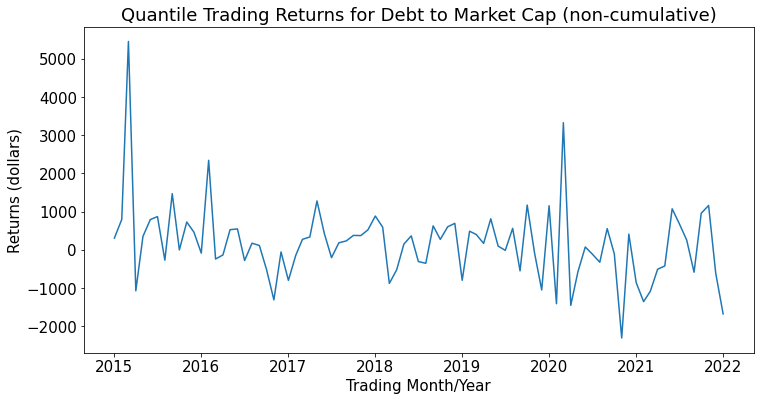

In [356]:
d_mcap_data = ratio_df[['index', 'ticker', 'Debt to Market Cap', 'adj_close']]
pnl_dtmc, months_to_chart = trading_strategy(d_mcap_data, 'Debt to Market Cap')


plt.title('Quantile Trading Returns for Debt to Market Cap (non-cumulative)')
plt.xlabel('Trading Month/Year')
plt.ylabel('Returns (dollars)')
plt.plot(months_to_chart, pnl_dtmc)
plt.show()

It is difficult to see the overall trend of returns, though it seems to hover around 0, or slightly higher. Let's convert this to cumulative returns

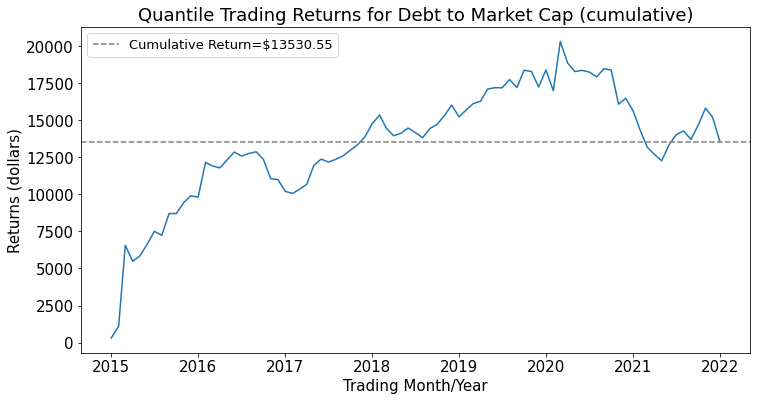

In [357]:
cumulative_returns_dtmc = np.cumsum(pnl_dtmc)
final_return_dtmc = cumulative_returns_dtmc[-1]
plt.title('Quantile Trading Returns for Debt to Market Cap (cumulative)')
plt.xlabel('Trading Month/Year')
plt.ylabel('Returns (dollars)')
plt.plot(months_to_chart, cumulative_returns_dtmc)
plt.axhline(y=final_return_dtmc, color='gray', linestyle='--', label=f'Cumulative Return=${round(final_return_dtmc,2)}')
plt.legend(loc='best')
plt.show()

This chart makes it much more clear that this is a profitable strategy, with a total cumulative return of about $13,000. Given that we started with $10,000 on both quantiles, this seems a fairly good return.

### Return on Capital

If we assume the initial capital is ten times the notional, that would make our initial capital $200,000. 

In [358]:
roc_dtmc = final_return_dtmc / 200_000
print(f'The total return on capital is: {round(100*roc_dtmc,2)}%')
print(f'The total annualized return on capital is: {round(100*roc_dtmc/7,2)}%')

The total return on capital is: 6.77%
The total annualized return on capital is: 0.97%


## Analysis (Return on Investment)

Now let's use Return on Investment. Let's create a trading strategy where we buy the top 10% of return on investment and short the bottom 10% of return on investment. At the end of the month we will close our positions and calculate pnl. We will do this for each month in the time frame (Jan 2015 - Jan 2022). For simplicity we will buy $10,000 spread equally amongst the stocks at the top and the bottom of the quantile for an initial flat position. We will also make the assumption that a higher return on investment is better, and thus will go long those stocks and short the stocks with lower return on investment.

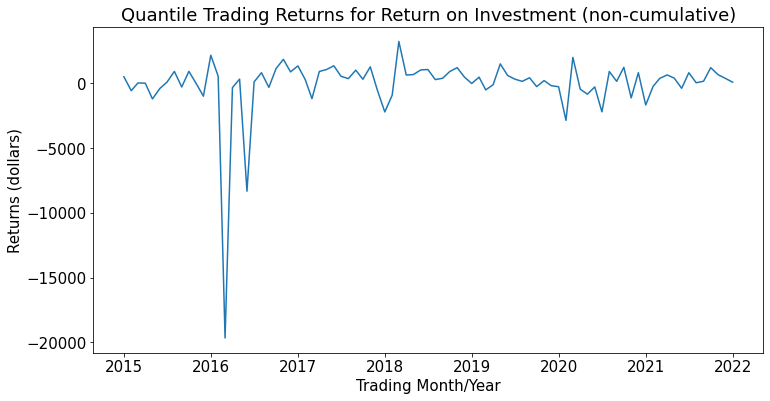

In [359]:
roi_data = ratio_df[['index', 'ticker', 'Return on Investment', 'adj_close']]
pnl_roi, months_to_chart = trading_strategy(roi_data, 'Return on Investment', lower_is_better=False)

plt.title('Quantile Trading Returns for Return on Investment (non-cumulative)')
plt.xlabel('Trading Month/Year')
plt.ylabel('Returns (dollars)')
plt.plot(months_to_chart, pnl_roi)
plt.show()

This chart appears to have a few very large negative return months, which may wipe out any small gains seen in the other months. On average it seems to hover around zero, though again the scale may be off due to the few outlier months.

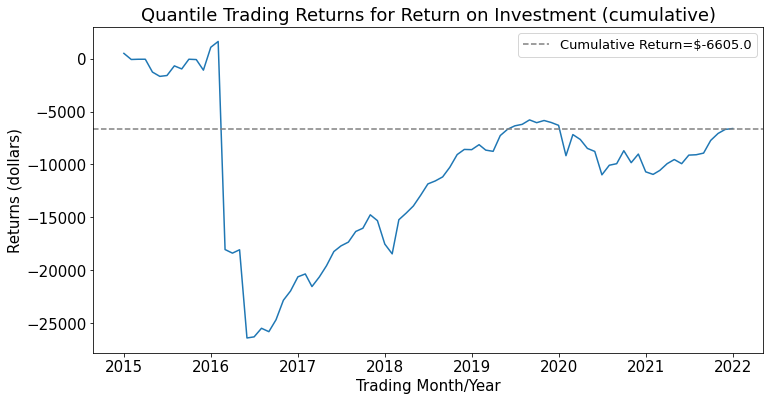

In [360]:
cumulative_returns_roi = np.cumsum(pnl_roi)
final_return_roi = cumulative_returns_roi[-1]
plt.title('Quantile Trading Returns for Return on Investment (cumulative)')
plt.xlabel('Trading Month/Year')
plt.ylabel('Returns (dollars)')
plt.plot(months_to_chart, cumulative_returns_roi)
plt.axhline(y=final_return_roi, color='gray', linestyle='--', label=f'Cumulative Return=${round(final_return_roi,2)}')
plt.legend(loc='best')
plt.show()

The graph above makes it clear that our intuition was correct, and that a few bad months using Return on Investment to invest wiped out all other gains. This result is not entirely surprising, as ROI on its own is likely not a very good indicator of future performance of a stock. ROI's may be highly sector specific, or may have other compounding variables that would make a straight quantile a poor measure for determining what is a 'high' ROI compared to other stocks. Improvements for this strategy would be to take the top few stocks out of each sector, or combine ROI with other ratios to get a more complete picture of the value of the stock. Another improvement we could make to this strategy would be to implement a stop-loss, so that if we saw the markets moving against us (like we did in 2016), we could close the positions early and reopen them the next month.

### Return on Capital

If we assume the initial capital is ten times the notional, that would make our initial capital $200,000.

In [361]:
roc_roi = final_return_roi / 200_000
print(f'The total return on capital is: {round(100*roc_roi,2)}%')
print(f'The total annualized return on capital is: {round(100*roc_roi/7,2)}%')

The total return on capital is: -3.3%
The total annualized return on capital is: -0.47%


## Analysis (Price to Earnings)

Now look at Price to Earnings. Let's create a trading strategy where we buy the top 10% of price to earnings and short the bottom 10% of price to earnings. At the end of the month we will close our positions and calculate pnl. We will do this for each month in the time frame (Jan 2015 - Jan 2022). For simplicity we will buy $10,000 spread equally amongst the stocks at the top and the bottom of the quantile for an initial flat position. We will also make the assumption that a lower price to earnings ratio is better, and thus will go long those stocks and short the stocks with a higher price to earnings ratio.

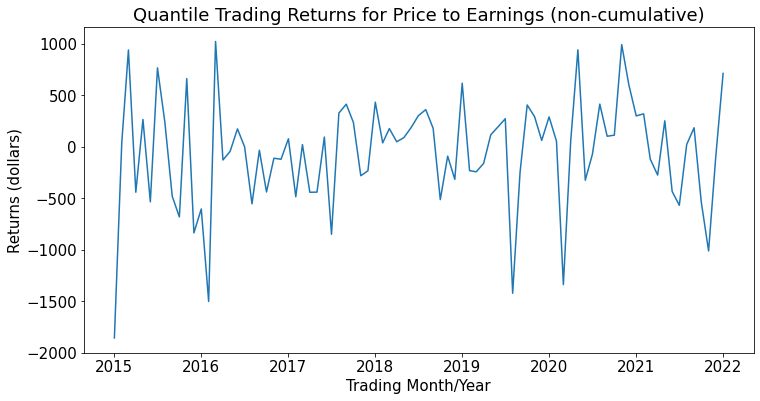

In [362]:
pe_data = ratio_df[['index', 'ticker', 'Price to Earnings', 'adj_close']]
pnl_pe, months_to_chart = trading_strategy(pe_data, 'Price to Earnings')

plt.title('Quantile Trading Returns for Price to Earnings (non-cumulative)')
plt.xlabel('Trading Month/Year')
plt.ylabel('Returns (dollars)')
plt.plot(months_to_chart, pnl_pe)
plt.show()

Once again, we see a fairly large spread of returns over the course of the seven years, but without the very large negative outliers we saw in the ROI returns. 

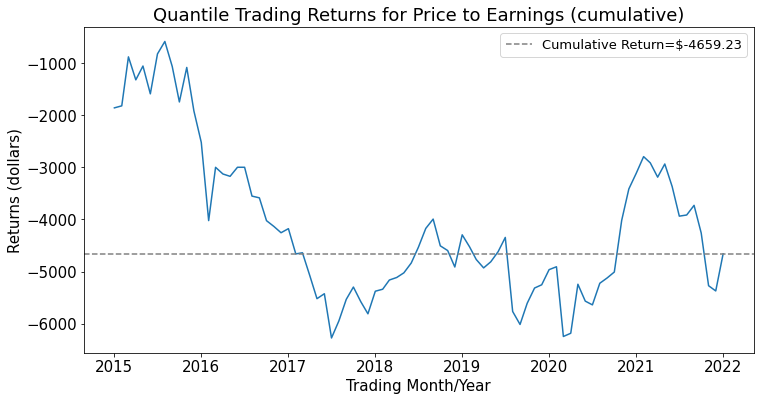

In [363]:
cumulative_returns_pe = np.cumsum(pnl_pe)
final_return_pe = cumulative_returns_pe[-1]
plt.title('Quantile Trading Returns for Price to Earnings (cumulative)')
plt.xlabel('Trading Month/Year')
plt.ylabel('Returns (dollars)')
plt.plot(months_to_chart, cumulative_returns_pe)
plt.axhline(y=final_return_pe, color='gray', linestyle='--', label=f'Cumulative Return=${round(final_return_pe,2)}')
plt.legend(loc='best')
plt.show()

In spite of the tighter spread of returns, we do see an overall negative return on this strategy. It is not surprising that this ocurred, as P/E by itself is not a good enough indicator to base a trading strategy on. Once again I would recommend trying to break things out by sector to get P/E ratios that are more related to one another, as a stock from a sector with a very high P/E may be included when it shouldn't, and vice versa for stocks from sectors with overall lower P/E ratios. 

### Return on Capital

If we assume the initial capital is ten times the notional, that would make our initial capital $200,000.

In [364]:
roc_pe = final_return_pe / 200_000
print(f'The total return on capital is: {round(100*roc_pe,2)}%')
print(f'The total annualized return on capital is: {round(100*roc_pe/7,2)}%')

The total return on capital is: -2.33%
The total annualized return on capital is: -0.33%


## Analysis (Debt to Market Ratio and Price to Earnings)

Let's use both Debt to Market Ratio and Price to Earnings combined for our last strategy. Let's create a trading strategy where we buy the top 10% of the ratio and short the bottom 10% of the ratio. At the end of the month we will close our positions and calculate pnl. We will do this for each month in the time frame (Jan 2015 - Jan 2022). For simplicity we will buy $10,000 spread equally amongst the stocks at the top and the bottom of the quantile for an initial flat position. We will also make the assumption that a lower combination of the ratios is better, and thus will go long those stocks and short the stocks with a higher combination of the ratios. Since debt to market ratio is generally a number on a much smaller scale, and because it seemed to be the best strategy from above, we will scale it by 1000 before adding it to the price to earnings for the new ratio used in this strategy.

In [365]:
ratio_df['Combo Ratio'] = ratio_df['Debt to Market Cap'] * 1000 + ratio_df['Price to Earnings']
display(ratio_df)

,index,ticker,tot_debt_tot_equity,ret_invst,mkt_val,per_type,net_lterm_debt,tot_lterm_debt,eps_diluted_net,basic_net_eps,shares_out,adj_close,date,Return on Investment,Debt to Market Cap,Price to Earnings,Price to Earnings 2,Combo Ratio
0,2015-01-02,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,35.849939,2015-01-02,0.000545,0.227042,5.233568,5.106829,232.275967
1,2015-01-03,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,35.849939,2015-01-02,0.000545,0.227042,5.233568,5.106829,232.275967
2,2015-01-04,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,35.849939,2015-01-02,0.000545,0.227042,5.233568,5.106829,232.275967
3,2015-01-05,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,34.375776,2015-01-05,0.000545,0.227042,5.018361,4.896834,232.060761
4,2015-01-06,VLO,0.3006,13.9691,25457.80,Q,-176.0,5780.0,6.85,7.02,514.30,33.955604,2015-01-06,0.000545,0.227042,4.957022,4.836981,231.999422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602168,2022-01-27,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47,39.700000,2022-01-27,0.001330,0.074548,68.448276,67.288136,142.995897
602169,2022-01-28,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47,39.410000,2022-01-28,0.001330,0.074548,67.948276,66.796610,142.495897
602170,2022-01-29,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47,39.410000,2022-01-28,0.001330,0.074548,67.948276,66.796610,142.495897
602171,2022-01-30,AIR,0.1025,1.8735,1384.35,Q,-24.7,103.2,0.58,0.59,35.47,39.410000,2022-01-28,0.001330,0.074548,67.948276,66.796610,142.495897


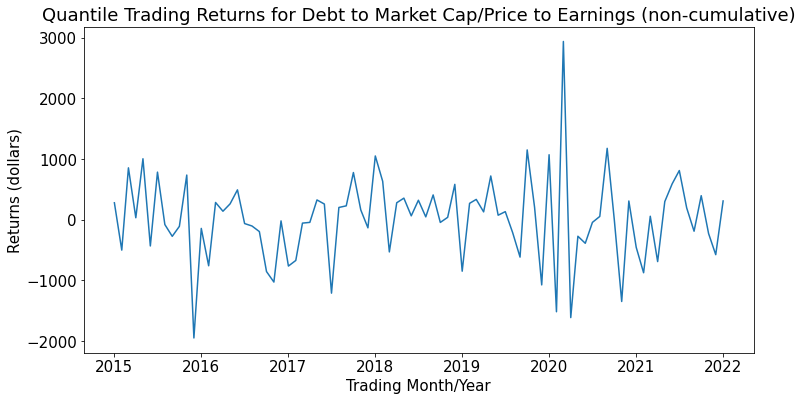

In [366]:
combo_data = ratio_df[['index', 'ticker', 'Combo Ratio', 'adj_close']]
pnl, months_to_chart = trading_strategy(combo_data, 'Combo Ratio')

plt.title('Quantile Trading Returns for Debt to Market Cap/Price to Earnings (non-cumulative)')
plt.xlabel('Trading Month/Year')
plt.ylabel('Returns (dollars)')
plt.plot(months_to_chart, pnl)
plt.show()

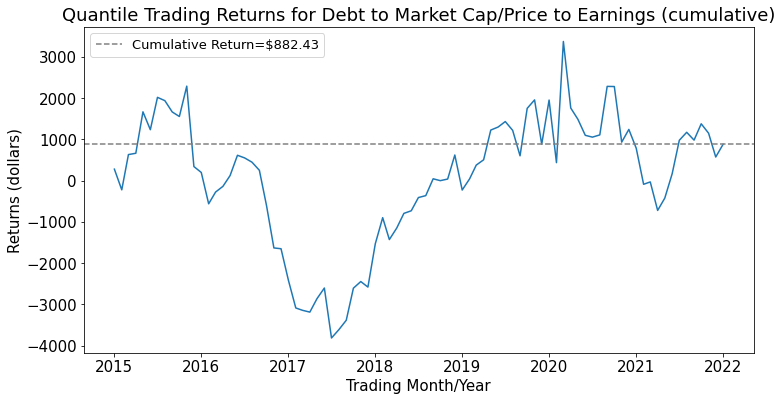

In [367]:
cumulative_returns = np.cumsum(pnl)
final_return = cumulative_returns[-1]
plt.title('Quantile Trading Returns for Debt to Market Cap/Price to Earnings (cumulative)')
plt.xlabel('Trading Month/Year')
plt.ylabel('Returns (dollars)')
plt.plot(months_to_chart, cumulative_returns)
plt.axhline(y=final_return, color='gray', linestyle='--', label=f'Cumulative Return=${round(final_return,2)}')
plt.legend(loc='best')
plt.show()

We see an overall positive return on this strategy, which is not unexpected given the heavy weighting for Debt to Market Ratio. However, the inclusion of the Price to Earnings did not help our first strategy at all.

### Return on Capital

If we assume the initial capital is ten times the notional, that would make our initial capital $200,000.

In [368]:
roc = final_return / 200_000
print(f'The total return on capital is: {round(100*roc,2)}%')
print(f'The total annualized return on capital is: {round(100*roc/7,2)}%')

The total return on capital is: 0.44%
The total annualized return on capital is: 0.06%


## Analysis (Debt to Market Cap, Changing Quantiles)

From our previous strategies, we've seen that using the Debt to Market Cap ratio gives us the best returns. As an experiment, let's play around with changing quantiles. Rather than 10% and 90%, I shall try 5% and 95%. At the end of the month we will still close our positions and calculate pnl. We will do this for each month in the time frame (Jan 2015 - Jan 2022). For simplicity we will buy $10,000 spread equally amongst the stocks at the top and the bottom of the quantile for an initial flat position. We will also make the assumption that a lower debt to market cap ratio is better, and thus will go long those stocks and short the stocks with higher debt to market cap. Using these new quantiles, we would expect that the returns would be better, as we've taken more extreme positions in the quantiles, and therefore invested the same amount of money in fewer stocks (increasing our positions in each).

In [369]:
print(f'As a reminder, our Debt to Market Cap return was ${round(final_return_dtmc, 2)}, with an annualized return of {round(100*roc_dtmc/7,2)}%')

As a reminder, our Debt to Market Cap return was $13530.55, with an annualized return of 0.97%


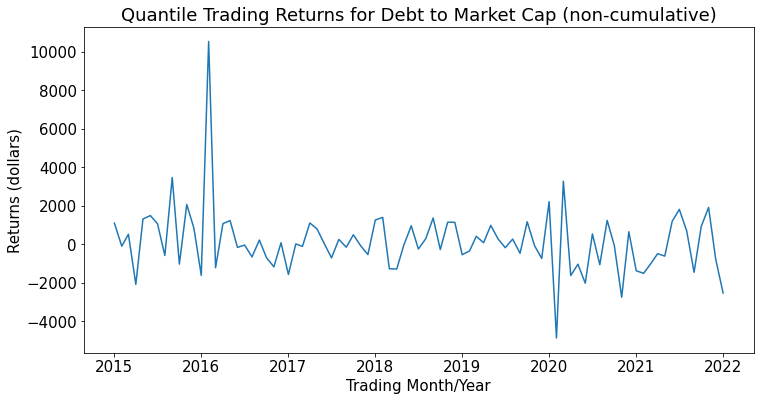

In [370]:
d_mcap_data = ratio_df[['index', 'ticker', 'Debt to Market Cap', 'adj_close']]
pnl_dtmc_2, months_to_chart = trading_strategy(d_mcap_data, 'Debt to Market Cap', lower_quantile=0.05, upper_quantile=0.95)


plt.title('Quantile Trading Returns for Debt to Market Cap (non-cumulative)')
plt.xlabel('Trading Month/Year')
plt.ylabel('Returns (dollars)')
plt.plot(months_to_chart, pnl_dtmc_2)
plt.show()

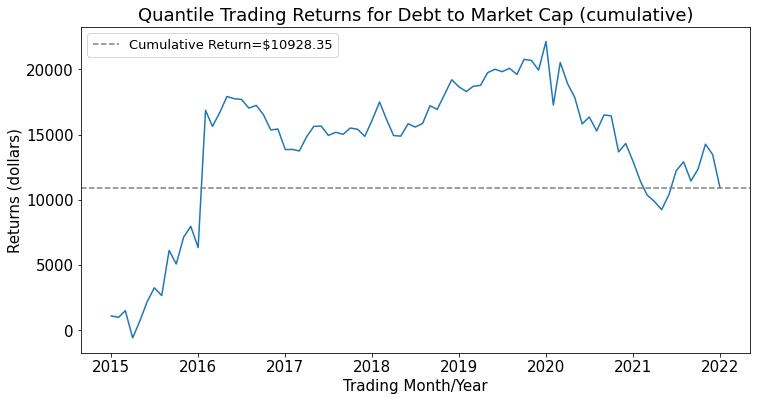

In [371]:
cumulative_returns_dtmc_2 = np.cumsum(pnl_dtmc_2)
final_return_dtmc_2 = cumulative_returns_dtmc_2[-1]
plt.title('Quantile Trading Returns for Debt to Market Cap (cumulative)')
plt.xlabel('Trading Month/Year')
plt.ylabel('Returns (dollars)')
plt.plot(months_to_chart, cumulative_returns_dtmc_2)
plt.axhline(y=final_return_dtmc_2, color='gray', linestyle='--', label=f'Cumulative Return=${round(final_return_dtmc_2,2)}')
plt.legend(loc='best')
plt.show()

We can see in this adjusted strategy that while we did still have positive returns, we did not do as well as the 10/90 quantiles. Let's try widening the quantiles now, to 15/85.

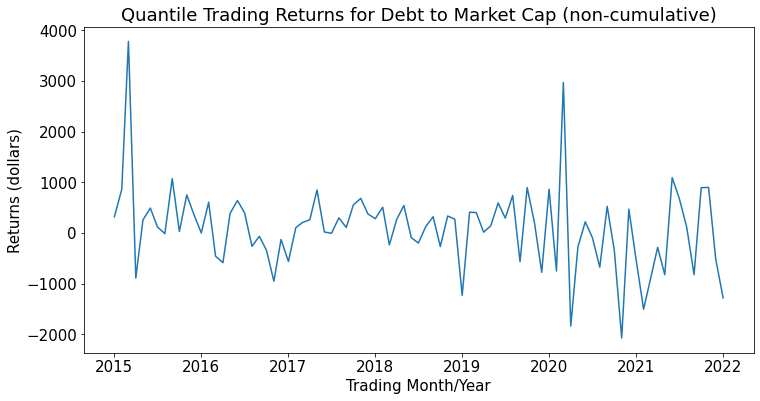

In [372]:
d_mcap_data = ratio_df[['index', 'ticker', 'Debt to Market Cap', 'adj_close']]
pnl_dtmc_3, months_to_chart = trading_strategy(d_mcap_data, 'Debt to Market Cap', lower_quantile=0.15, upper_quantile=0.85)


plt.title('Quantile Trading Returns for Debt to Market Cap (non-cumulative)')
plt.xlabel('Trading Month/Year')
plt.ylabel('Returns (dollars)')
plt.plot(months_to_chart, pnl_dtmc_3)
plt.show()

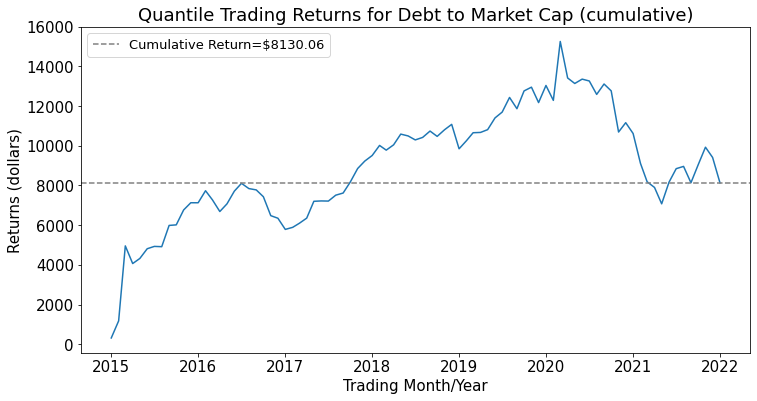

In [373]:
cumulative_returns_dtmc_3 = np.cumsum(pnl_dtmc_3)
final_return_dtmc_3 = cumulative_returns_dtmc_3[-1]
plt.title('Quantile Trading Returns for Debt to Market Cap (cumulative)')
plt.xlabel('Trading Month/Year')
plt.ylabel('Returns (dollars)')
plt.plot(months_to_chart, cumulative_returns_dtmc_3)
plt.axhline(y=final_return_dtmc_3, color='gray', linestyle='--', label=f'Cumulative Return=${round(final_return_dtmc_3,2)}')
plt.legend(loc='best')
plt.show()

Yet again, we see that this variation in the quantile strategy for Debt to Market Cap did not perform as well. It is interesting to note that all three variations on the quantiles seem to be very highly correlated (not surprisingly).

## Conclusion

It seems that using the 10/90 quantiles provides the best return, at least when using the Debt to Market Ratio as our indicator for trading. Overall using these ratios on their own did not prove to be a very good strategy, at least on the time frame provided. 

Other areas for investigation with this trading strategy would be to compare the returns from the Debt to Market Cap example to the returns on SPY, to see how highly correlated the strategy is to the market. Ideally, we'd like to find a strategy that provides returns beyond SPY, or that is in fact negatively correlated to SPY so that we could use it as a hedge to any market risk we may have in other strategies. 

Additionally running these strategies isolated by sectors would prove interesting, as oftentimes ratios such as these are only interesting to compare within sectors. We may also find that running these strategies on individual sectors may prove that they work better in certain sectors rather than others.

Lastly, to truly prove that this is a valuable strategy, we should backtest this on other timeframes. It may be that the only reason we saw positive return was due to overall market trends during this timeframe, and it would be interesting to backtest this against a timeframe where the market when through a downturn, to see if we could still generate positive returns.